In [1]:
%load_ext autoreload
%autoreload 2


# Imports

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import seaborn.objects as so
import shap
import xgboost as xgb


from matplotlib.colors import LinearSegmentedColormap

from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from src.data_processing.pipelines.ClassifierPipe import ClassifierPipe


# Reproduce processing pipeline 

In [10]:
DATA_PATH = '/Users/mds8301/iterm_data_storage/raw_data_raw_data.parquet.gzip'
SUBJECT_ID_PATH = '/Users/mds8301/Development/ENIGMA/results/experiments/xgb_regression_hyperopt/subjects.json'

processor_pipe = (ClassifierPipe(DATA_PATH)
                      .read_raw_data()
                      .bin_trial_count()
                      .calculate_max_min_signal()
                      .calculate_percent_avoid()
                      .drop_features(["event", "action", "day", "trial", "trial_count","num_avoids", "max_trial"])
                      .split_data(target = "ratio_avoid",
                                load_subject_ids = True, 
                                subject_ids_path = SUBJECT_ID_PATH, 
                                save_subject_ids=False)
                      .transform_data()
)
processor_pipe.processed_data


,mouse_id,sensor,sex,trial_count_bins,signal_max,signal_min,signal_trapz,pos_signal_trapz,neg_signal_trapz,ratio_avoid
0,0,D1,F,0,3.127942,-1.445911,183.380890,307.363281,-123.982407,0.178571
1,0,DA,F,0,2.314936,-3.262590,-107.717682,132.883179,-240.600861,0.178571
2,0,D1,F,0,2.974904,-1.432352,399.498169,459.798584,-60.300407,0.178571
3,0,D1,F,0,0.731579,-2.503899,-358.554230,24.004738,-382.558990,0.178571
4,0,D1,F,0,1.076792,-2.716747,-424.765411,24.113791,-448.879211,0.178571
...,...,...,...,...,...,...,...,...,...,...
12416,13,DA,M,18,2.598939,-2.246814,49.042274,189.407471,-140.365204,1.000000
12417,13,D2,M,17,3.042648,-1.698893,159.018143,244.892090,-85.873940,1.000000
12418,13,DA,M,17,3.537512,-2.393753,-82.977081,174.050079,-257.027161,1.000000
12419,13,D2,M,17,3.150901,-1.644451,145.029205,236.765778,-91.736565,1.000000


# Train Regressor using opimtized parameteres

In [11]:
best_params = {'booster': 'gbtree', 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 250, 'reg_lambda': 1.0, 'subsample': 0.8}

model = xgb.XGBRegressor(
        objective='reg:squarederror', 
        eval_metric=['rmse', 'mae'],
        **best_params)
model.fit(processor_pipe.X_train, processor_pipe.y_train)

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=['rmse', 'mae'],
             feature_types=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=7, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=250,
             n_jobs=None, num_parallel_tree=None, random_state=None, ...)

## Evalulate on dev set

In [12]:


mse_train = mean_squared_error(processor_pipe.y_train, model.predict(processor_pipe.X_train))
mse_dev = mean_squared_error(processor_pipe.y_dev, model.predict(processor_pipe.X_dev))
mse_test = mean_squared_error(processor_pipe.y_test, model.predict(processor_pipe.X_test))
print(f" MSE for optimzied model on train is {mse_train}")
print(f" MSE for optimzied model on development test is {mse_dev}")
print(f" MSE for optimzied model on test is {mse_test}")

 MSE for optimzied model on train is 0.0010875294315114317
 MSE for optimzied model on development test is 0.08712021375035517
 MSE for optimzied model on test is 0.024727210387382924


# Predict on test set

In [13]:
predicted_performance = model.predict(processor_pipe.X_test)

# Plotting test set vs inference 


In [30]:
def get_cols_from_pipeline(pipeline):
        num_cols = pipeline.processor.named_transformers_["num"].get_feature_names_out().tolist()
        cat_cols = pipeline.processor.named_transformers_["cat"].get_feature_names_out().tolist()
        return num_cols + cat_cols
def get_df_from_pipeline(pipeline, predicted_values):
        cols = get_cols_from_pipeline(pipeline)
        
        df = (pd.DataFrame(pipeline.X_test, columns=cols)
              .assign(predicted_values = predicted_values, 
                      true_values = pipeline.y_test.values))
        values_cat = ['predicted_values', 'true_values']

        return  (
                df
                .melt(id_vars = [col for col in df.columns if col not in values_cat],
                value_vars = values_cat, 
                var_name = "inference_cat",
                value_name='ratio_avoid')
                .assign(male = lambda df_: df_.sex_M.astype(bool))
                .drop(columns=['sex_M', 'sex_F'])
        )
                
testing_df = get_df_from_pipeline(processor_pipe, predicted_performance)
testing_df

,mouse_id,trial_count_bins,signal_max,signal_min,signal_trapz,pos_signal_trapz,neg_signal_trapz,sensor_D1,sensor_D2,sensor_DA,inference_cat,ratio_avoid,male
0,-0.249856,-1.675206,-0.695553,0.523437,-0.173122,-0.626593,0.319242,1.0,0.0,0.0,predicted_values,0.145501,True
1,-0.249856,-1.675206,1.579697,0.395103,-0.471041,-0.638406,-0.163517,0.0,0.0,1.0,predicted_values,0.146496,True
2,-0.249856,-1.152047,-0.275176,-0.266413,-1.237924,-1.166851,-0.924201,1.0,0.0,0.0,predicted_values,0.376048,True
3,-0.249856,-1.152047,2.912181,0.089504,0.064025,0.220974,-0.107655,0.0,0.0,1.0,predicted_values,0.543204,True
4,-0.249856,-1.675206,0.478908,1.054361,0.778187,0.196755,1.100447,1.0,0.0,0.0,predicted_values,0.128752,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5221,1.587260,1.289363,-1.174288,0.112548,-0.242651,-1.082070,0.644718,0.0,1.0,0.0,true_values,0.928571,False
5222,1.587260,1.289363,0.103718,-0.143197,0.007067,0.237800,-0.218420,0.0,0.0,1.0,true_values,0.928571,False
5223,1.587260,1.289363,-1.348900,0.183924,-0.525469,-1.082329,0.175827,0.0,1.0,0.0,true_values,0.928571,False
5224,1.587260,1.289363,-1.292167,0.186598,-0.245389,-1.072643,0.631053,0.0,1.0,0.0,true_values,0.928571,False


In [56]:
len(testing_df.trial_count_bins.unique())

20

([<matplotlib.axis.XTick at 0x353ab8090>,
 [Text(-1.6752060832440394, 0, '0'),
  Text(-1.5008196416537938, 0, '1'),
  Text(-1.3264332000635481, 0, '2'),
  Text(-1.1520467584733025, 0, '3'),
  Text(-0.977660316883057, 0, '4'),
  Text(-0.8032738752928114, 0, '5'),
  Text(-0.6288874337025657, 0, '6'),
  Text(-0.45450099211232015, 0, '7'),
  Text(-0.28011455052207457, 0, '8'),
  Text(-0.10572810893182898, 0, '9'),
  Text(0.06865833265841663, 0, '10'),
  Text(0.24304477424866222, 0, '11'),
  Text(0.4174312158389078, 0, '12'),
  Text(0.5918176574291534, 0, '13'),
  Text(0.766204099019399, 0, '14'),
  Text(0.9405905406096445, 0, '15'),
  Text(1.1149769821998903, 0, '16'),
  Text(1.2893634237901357, 0, '17'),
  Text(1.4637498653803813, 0, '18'),
  Text(1.638136306970627, 0, '19')])

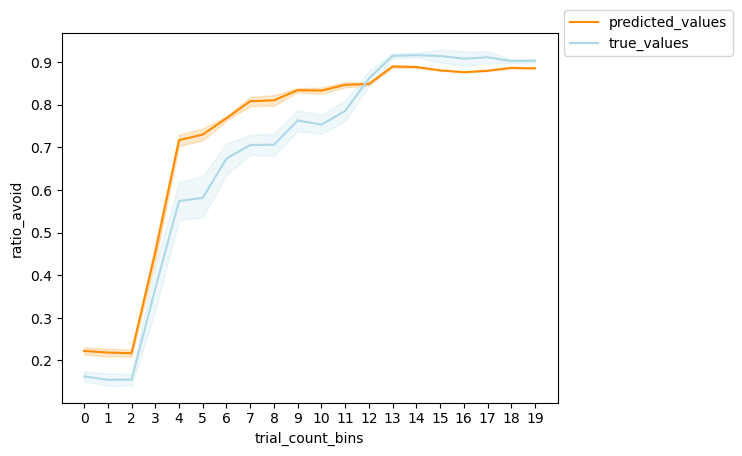

In [65]:
fig, ax = plt.subplots()
sns.lineplot(data=testing_df, x='trial_count_bins', y='ratio_avoid', hue='inference_cat', palette=['darkorange', 'lightblue'], ax = ax)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 1.0))
plt.xticks(sorted(testing_df.trial_count_bins.unique()), range(0,20,1))



# ax.set_xlabel('Trial_bin', fontsize=10)
# ax.set_ylabel('Ratio Avoid', fontsize=14)
# ax.set_title('Performance across trial bins', fontsize = 18)
# sns.despine()

---
# Feature Importance




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


Text(0.5, 1.0, 'Feature Importance')

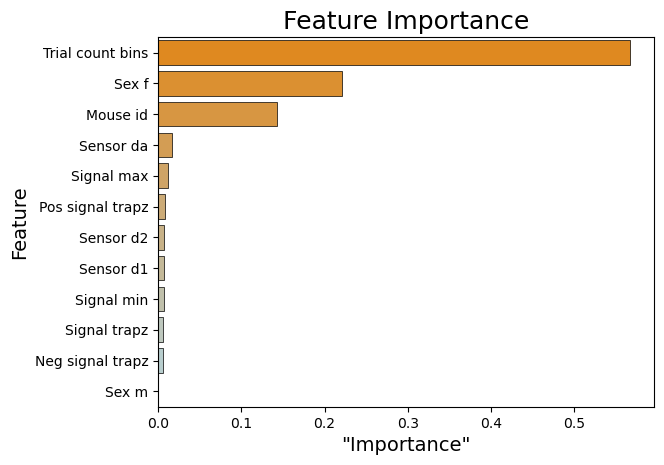

In [15]:
from matplotlib.colors import LinearSegmentedColormap


cols = get_cols_from_pipeline(processor_pipe)
feature_importance = (
    pd.Series(
    model.feature_importances_, index = cols)
    .sort_values(ascending=False)
)
color_map = LinearSegmentedColormap.from_list("orange_blue",["#FF8C00","#ADD8E6"])
colors = [color_map(i) for i in np.linspace(0, 1, len(feature_importance))]

# feature_importance
col_labels = [col.capitalize().replace('_', ' ') for col in feature_importance.index]
fig, ax = plt.subplots()
sns.barplot(x=feature_importance, y=feature_importance.index, ax=ax, linewidth=0.5, palette=colors, edgecolor='black')
ax.set_yticklabels(col_labels)
# ax.set_xscale("log")
ax.set_xlabel('"Importance"', fontsize=14)
ax.set_ylabel('Feature', fontsize=14)
ax.set_title('Feature Importance', fontsize = 18)

In [16]:
testing_df

,mouse_id,trial_count_bins,signal_max,signal_min,signal_trapz,pos_signal_trapz,neg_signal_trapz,sensor_D1,sensor_D2,sensor_DA,inference_cat,ratio_avoid,male
0,-0.249856,-1.675206,-0.695553,0.523437,-0.173122,-0.626593,0.319242,1.0,0.0,0.0,predicted_values,0.145501,True
1,-0.249856,-1.675206,1.579697,0.395103,-0.471041,-0.638406,-0.163517,0.0,0.0,1.0,predicted_values,0.146496,True
2,-0.249856,-1.152047,-0.275176,-0.266413,-1.237924,-1.166851,-0.924201,1.0,0.0,0.0,predicted_values,0.376048,True
3,-0.249856,-1.152047,2.912181,0.089504,0.064025,0.220974,-0.107655,0.0,0.0,1.0,predicted_values,0.543204,True
4,-0.249856,-1.675206,0.478908,1.054361,0.778187,0.196755,1.100447,1.0,0.0,0.0,predicted_values,0.128752,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5221,1.587260,1.289363,-1.174288,0.112548,-0.242651,-1.082070,0.644718,0.0,1.0,0.0,true_values,0.928571,False
5222,1.587260,1.289363,0.103718,-0.143197,0.007067,0.237800,-0.218420,0.0,0.0,1.0,true_values,0.928571,False
5223,1.587260,1.289363,-1.348900,0.183924,-0.525469,-1.082329,0.175827,0.0,1.0,0.0,true_values,0.928571,False
5224,1.587260,1.289363,-1.292167,0.186598,-0.245389,-1.072643,0.631053,0.0,1.0,0.0,true_values,0.928571,False


## SHAP from feature space

In [17]:
shap_values = shap.TreeExplainer(model).shap_values(processor_pipe.X_test)
shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(processor_pipe.X_test)

[10:16:53] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


In [19]:
x_train_df = pd.DataFrame(processor_pipe.X_train, columns=cols)

explainer = shap.TreeExplainer(model,x_train_df)
explanation = explainer(x_train_df)

[10:17:13] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
 99%|===================| 7869/7922 [00:48<00:00]        

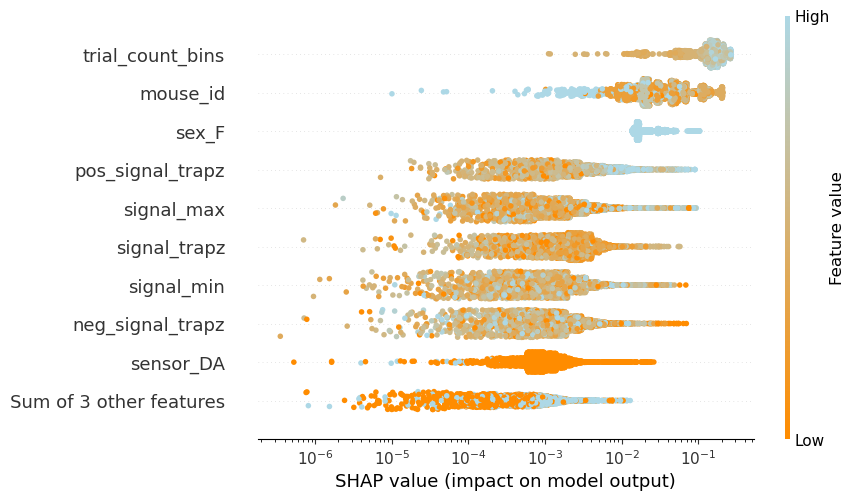

In [20]:
shap.plots.beeswarm(explanation, color=color_map, show=False)
plt.xscale("log")

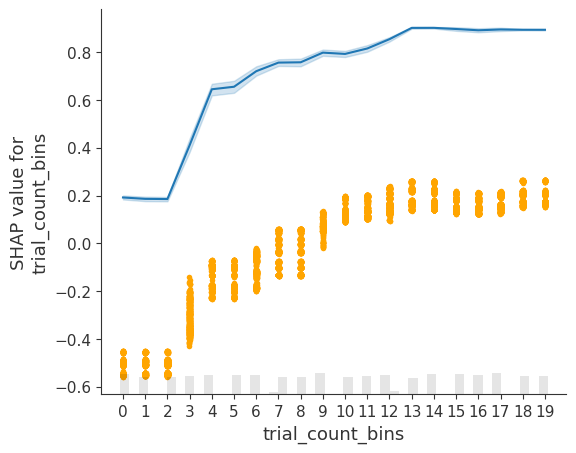

In [75]:


shap.plots.scatter(explanation[:,'trial_count_bins'], show=False, color='orange')
plt.xticks(sorted(testing_df.trial_count_bins.unique()), np.arange(0,20,1))



plt.show()


## Dimentional Reduction of SHAP

[10:18:44] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
 99%|===================| 7804/7922 [00:49<00:00]        

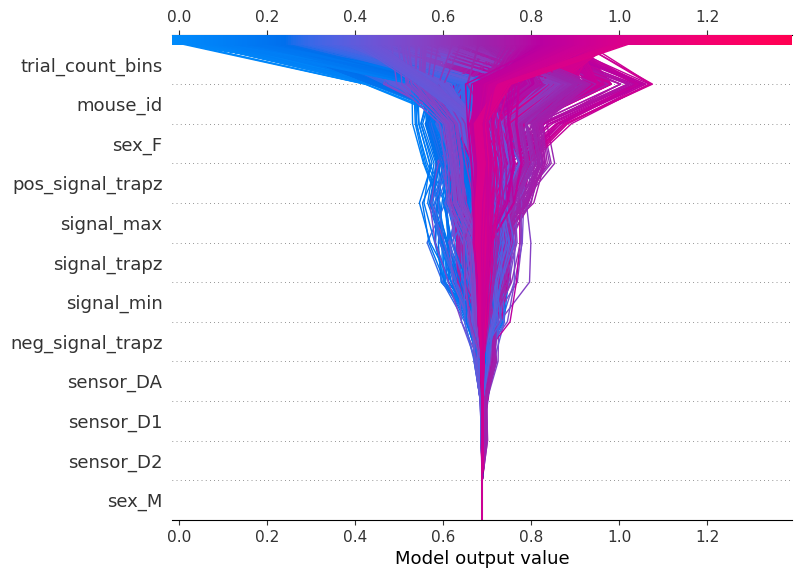

In [22]:
short_explainer = shap.TreeExplainer(model, x_train_df)
short_shap = short_explainer.shap_values(x_train_df)
shap.decision_plot(short_explainer.expected_value, short_shap, features = cols, ignore_warnings= True)

## Day vs Trial bins

In [23]:

day_processsor = (ClassifierPipe(DATA_PATH)
                      .read_raw_data()
                      .calculate_max_min_signal()
                      .calculate_percent_avoid()
                      .drop_features(["event", "action", "trial", "trial_count", "num_avoids", "max_trial"])
                      .split_data(target = "ratio_avoid",
                                load_subject_ids = True, 
                                subject_ids_path = SUBJECT_ID_PATH, 
                                save_subject_ids=False)
                      .transform_data()
)


best_params = {'booster': 'gbtree', 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 250, 'reg_lambda': 1.0, 'subsample': 0.8}

day_model = xgb.XGBRegressor(
        objective='reg:squarederror', 
        eval_metric=['rmse', 'mae'],
        **best_params)
day_model.fit(day_processsor.X_train, day_processsor.y_train)


is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=['rmse', 'mae'],
             feature_types=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=7, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=250,
             n_jobs=None, num_parallel_tree=None, random_state=None, ...)

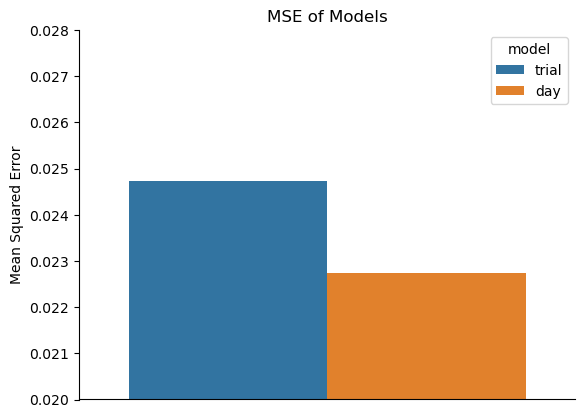

In [129]:
day_train_score = mean_squared_error(day_processsor.y_train, day_model.predict(day_processsor.X_train))
day_dev_score = mean_squared_error(day_processsor.y_dev, day_model.predict(day_processsor.X_dev))
day_test_score = mean_squared_error(day_processsor.y_test, day_model.predict(day_processsor.X_test))
trial_train_score = mean_squared_error(processor_pipe.y_train, model.predict(processor_pipe.X_train))
trial_dev_score = mean_squared_error(processor_pipe.y_dev, model.predict(processor_pipe.X_dev))
trial_mse_test = mean_squared_error(processor_pipe.y_test, model.predict(processor_pipe.X_test))

scores = {'train': [trial_train_score, day_train_score], 
          'dev': [trial_dev_score, day_dev_score], 
          'test': [trial_mse_test, day_test_score]}

scores_df = (pd.DataFrame(scores, index=['trial', 'day'])
             .reset_index()
             .melt(id_vars=['index'], 
                   var_name='split', value_name='mse')
             .rename(columns={'index': 'model'})
)
scores_df
sns.barplot(data=scores_df.query("split == 'test'"), x='split', y='mse', hue='model')
plt.ylabel('Mean Squared Error')
plt.xlabel('')
plt.xticks([])
plt.title('MSE of Models')
plt.ylim(0.02, 0.028)
sns.despine()

